In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import chart_studio.plotly as py
import plotly.offline as py
# from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff

# init_notebook_mode(connected=True)

In [7]:
ff_nodes = {'merced': 'IFR at Shaffer Bridge', 'tuolumne': 'IFR at La Grange'}
fnf_nodes = {'merced': 'Lake McClure', 'tuolumne': 'TUO_01 Inflow'}
storage_nodes = {'merced': 'Lake McClure', 'tuolumne': 'Don Pedro Reservoir'}

In [8]:
debug = True

# root_path = r'C:\Users\david\Box\CERC-WET\Task7_San_Joaquin_Model\pywr_models\results\Functional flows with future energy prices - 2021-03-28\tuolumne\historical\Livneh'
climate = 'historical/Livneh'
basin = 'tuolumne'


node = fnf_nodes[basin]
reservoir = storage_nodes[basin]

basin_full = '{} River'.format(basin.title())
# run_name = 'Functional flows with future energy prices - 2021-03-28'
run_name = 'Functional Flows Historical'
sierra_data_path = r'C:\Users\david\Box\CERC-WET\Task7_San_Joaquin_Model\pywr_models\data'
sierra_results_path = r'C:\Users\david\PycharmProjects\sierra-pywr\results'
results_path = os.path.join(sierra_results_path, run_name, basin, climate)
if not os.path.exists(results_path):
    raise Exception('Results path not found: {}'.format(results_path))
# print(results_path)

fnf_root_path = os.path.join(sierra_data_path, basin_full, 'hydrology', climate, 'preprocessed')
fnf_path = os.path.join(fnf_root_path, 'full_natural_flow_daily_mcm.csv'.format(fnf_nodes[basin]))
# print(fnf_path)

In [9]:
def load_data(filename, node):
    path = os.path.join(results_path, filename)
    if debug:
        df = pd.read_csv(path, parse_dates=True, index_col=0, header=0)
        df = df.loc[:,node].to_frame()
#     df = pd.read_csv(path, parse_dates=True, index_col=0, header=[0,1,2])
#     df = df.loc[:, ([node], ['2009'], ['Functional Flows'])]
#     if node:
#         df = df.loc[:,node]
#     if scenario:
#         df = df.loc[:,scenario]
        
#     return df.to_frame()
    return df

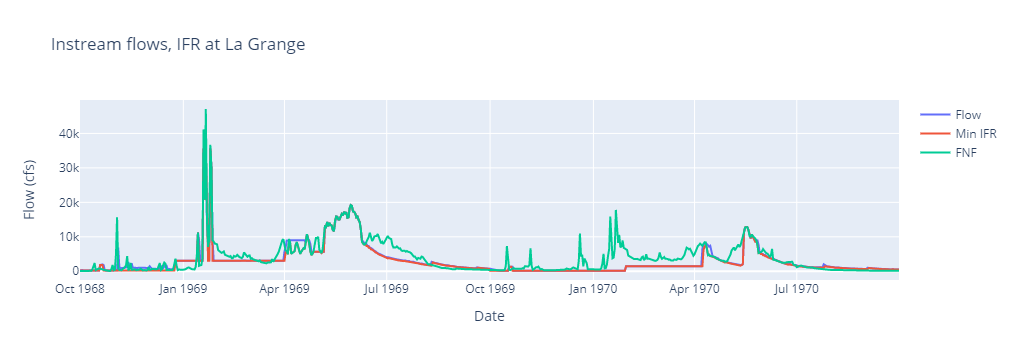

In [10]:
start = '1968-10-01'
end = '1970-09-30'

# Load data

node = ff_nodes[basin]
df_flow = load_data('InstreamFlowRequirement_Flow_mcm.csv', node)
df_ifr_min = load_data('InstreamFlowRequirement_Min Flow_mcm.csv', node)
df_storage = load_data('Reservoir_Storage_mcm.csv', reservoir)

# df_storage = load_data('')

df = pd.concat([df_flow, df_ifr_min], axis=1)
df.columns = ['Flow', 'Min IFR']
df *= 35.315 * 1e6 / 24 / 3600
# print(df.head())

# load fnf
df_fnf = pd.read_csv(fnf_path, index_col=0, parse_dates=True, header=0)
df_fnf *= 1 / 0.0864 * 35.315
df_fnf.head()

df_short = df.loc[start:end]
df_fnf_short = df_fnf.loc[start:end]

# Plot data

line1 = go.Scatter(x=df_short.index, y=df_short['Flow'], name='Flow')
line2 = go.Scatter(x=df_short.index, y=df_short['Min IFR'], name='Min IFR')
line3 = go.Scatter(x=df_fnf_short.index, y=df_fnf_short['flow'], name='FNF')

data = [line1, line2, line3]

layout = go.Layout(title="Instream flows, " + node,
                xaxis=dict(title='Date'),
                yaxis=dict(title='Flow (cfs)'))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='instream_flows')

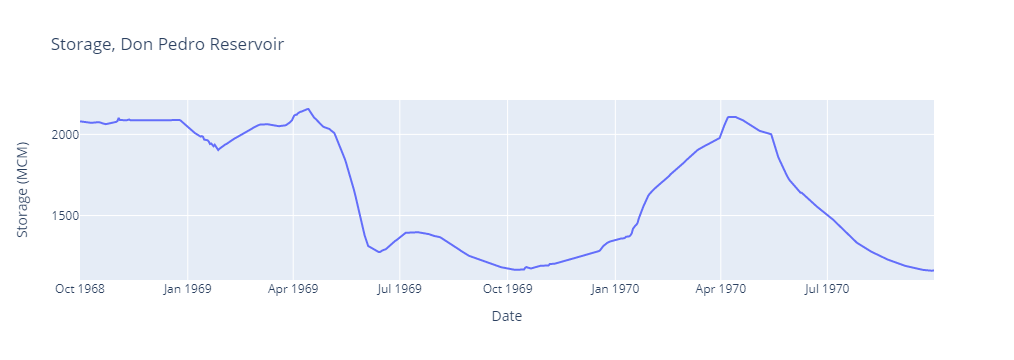

In [12]:
df_storage_short = df_storage.loc[start:end]
line1 = go.Scatter(x=df_storage_short.index, y=df_storage_short[reservoir], name='Storage')

data = [line1]

layout = go.Layout(title="Storage, " + reservoir,
                xaxis=dict(title='Date'),
                yaxis=dict(title='Storage (MCM)'))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='storage')